In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

# Function to read the combined XYZ file and extract water molecule positions
def read_combined_xyz(input_file):
    water_positions = {'O': [], 'H': []}

    with open(input_file, 'r') as file:
        lines = file.readlines()

    for line in lines[2:]:  # Skip the first two lines (atom count and comment)
        parts = line.split()
        atom_type = parts[0]
        x, y, z = map(float, parts[1:4])

        # Classify based on atom type
        if atom_type == 'O':
            water_positions['O'].append((x, y, z))
        elif atom_type == 'H':
            water_positions['H'].append((x, y, z))

    return water_positions

# Function to cluster water molecules into layers based on z-coordinate
def cluster_water_layers(water_positions, layer_thickness=2):
    positions = water_positions['O']
    z_coords = np.array([pos[2] for pos in positions])
    positions = np.array(positions)

    # Sort positions based on z-coordinate
    sorted_indices = np.argsort(z_coords)
    sorted_positions = positions[sorted_indices]

    # Initialize layers
    layers = []
    current_layer = [sorted_positions[0]]

    # Cluster molecules into layers based on z-coordinate differences
    for pos in sorted_positions[1:]:
        if abs(pos[2] - current_layer[0][2]) <= layer_thickness:
            current_layer.append(pos)
        else:
            layers.append(current_layer)
            current_layer = [pos]

    # Add the last layer
    if current_layer:
        layers.append(current_layer)

    return layers

# Function to calculate average z-location, standard deviation, and average inter-layer distance
def calculate_layer_properties(layers, min_molecules=4):
    # Filter out layers with fewer than 'min_molecules' water molecules
    filtered_layers = [layer for layer in layers if len(layer) >= min_molecules]

    if not filtered_layers:
        return [], [], 0, 0, []  # No valid layers after filtering

    avg_z_locations = []
    std_devs = []
    com_positions = []
    for layer in filtered_layers:
        z_coords = [pos[2] for pos in layer]
        avg_z = np.mean(z_coords)
        std_dev = np.std(z_coords)
        avg_z_locations.append(avg_z)
        std_devs.append(std_dev)
        # Compute COM for the layer
        com = np.mean(layer, axis=0)
        com_positions.append(com)

    # Calculate average inter-layer distance
    if len(avg_z_locations) > 1:
        avg_distances = [abs(avg_z_locations[i] - avg_z_locations[i-1]) for i in range(1, len(avg_z_locations))]
        avg_inter_layer_distance = np.mean(avg_distances)
    else:
        avg_inter_layer_distance = 0  # Only one valid layer, so no inter-layer distance

    # Calculate average of standard deviations across valid layers
    avg_std_dev_across_layers = np.mean(std_devs)

    return avg_z_locations, std_devs, avg_inter_layer_distance, avg_std_dev_across_layers, filtered_layers, com_positions

# Function to analyze layers and compute COM and distances
def analyze_layers(layers):
    all_distances = []
    for i, layer in enumerate(layers):
        positions = np.array(layer)
        # Compute COM by averaging positions
        com = np.mean(positions, axis=0)
        print(f"Layer {i+1} center of mass: x={com[0]:.3f}, y={com[1]:.3f}, z={com[2]:.3f}")
        # Compute distances of each oxygen atom to the COM
        distances = np.linalg.norm(positions - com, axis=1)
        # Compute mean distance from center
        mean_distance = np.mean(distances)
        print(f"Layer {i+1} mean distance from center: {mean_distance:.3f} Å")
        # Collect distances for PDF
        all_distances.extend(distances)

    return all_distances

# Function to analyze distances between layer COMs
def analyze_layer_com_distances(com_positions):
    com_positions = np.array(com_positions)
    com_distances = []
    for i in range(len(com_positions) - 1):
        # Compute distance between COMs of adjacent layers
        distance = np.linalg.norm(com_positions[i+1] - com_positions[i])
        com_distances.append(distance)

    # Print distances
    for i, distance in enumerate(com_distances):
        print(f"Distance between Layer {i+1} and Layer {i+2} COMs: {distance:.3f} Å")

    return com_distances

# List of configurations and their corresponding min_molecules
configurations = {
    'AA': 5,
    'AR': 4,
    'AAR': 4,
    'Inner': 4,
    'Outer': 4
}

# Initialize dictionaries to store data for plotting
oxygen_com_distances_data = {}
layer_com_distances_data = {}

for config, min_molecules in configurations.items():
    folder = config
    input_file = os.path.join(folder, 'combined_structure.xyz')
    if not os.path.isfile(input_file):
        print(f"File {input_file} not found. Skipping configuration {config}.")
        continue

    print(f"\nProcessing configuration: {config}")
    # Read the combined XYZ file
    water_positions = read_combined_xyz(input_file)

    # Cluster water molecules into layers
    layers = cluster_water_layers(water_positions)

    # Calculate average z-location, standard deviation, and average inter-layer distance
    avg_z_locations, std_devs, avg_inter_layer_distance, avg_std_dev_across_layers, filtered_layers, com_positions = calculate_layer_properties(layers, min_molecules=min_molecules)

    # Output results
    if avg_z_locations:
        print(f"Total number of water layers with at least {min_molecules} molecules: {len(avg_z_locations)}")
        for i, (avg_z, std_dev) in enumerate(zip(avg_z_locations, std_devs), 1):
            print(f"Layer {i}: Average z-location = {avg_z:.3f} Å, Standard deviation = {std_dev:.3f} Å")

        if avg_inter_layer_distance > 0:
            print(f"Average distance between layers in the z-direction: {avg_inter_layer_distance:.3f} Å")
        else:
            print("Only one valid water layer detected, no inter-layer distance calculated.")

        print(f"Average standard deviation of z-direction within valid layers: {avg_std_dev_across_layers:.3f} Å")

        # Analyze layers for COM and distances
        oxygen_com_distances = analyze_layers(filtered_layers)
        oxygen_com_distances_data[config] = oxygen_com_distances

        # Analyze distances between layer COMs
        layer_com_distances = analyze_layer_com_distances(com_positions)
        layer_com_distances_data[config] = layer_com_distances
    else:
        print(f"No water layers with at least {min_molecules} molecules were found in configuration {config}.")







Processing configuration: AA
Total number of water layers with at least 5 molecules: 10
Layer 1: Average z-location = 0.862 Å, Standard deviation = 0.345 Å
Layer 2: Average z-location = 3.929 Å, Standard deviation = 0.374 Å
Layer 3: Average z-location = 7.051 Å, Standard deviation = 0.452 Å
Layer 4: Average z-location = 10.254 Å, Standard deviation = 0.375 Å
Layer 5: Average z-location = 13.513 Å, Standard deviation = 0.507 Å
Layer 6: Average z-location = 16.506 Å, Standard deviation = 0.513 Å
Layer 7: Average z-location = 19.469 Å, Standard deviation = 0.481 Å
Layer 8: Average z-location = 22.479 Å, Standard deviation = 0.405 Å
Layer 9: Average z-location = 25.615 Å, Standard deviation = 0.369 Å
Layer 10: Average z-location = 28.611 Å, Standard deviation = 0.430 Å
Average distance between layers in the z-direction: 3.083 Å
Average standard deviation of z-direction within valid layers: 0.425 Å
Layer 1 center of mass: x=15.084, y=15.677, z=0.862
Layer 1 mean distance from center: 2.716

<>:40: SyntaxWarning: invalid escape sequence '\,'
<>:40: SyntaxWarning: invalid escape sequence '\,'
/var/folders/ys/y877k0vd3bj8jdjg6z66dk980000gn/T/ipykernel_16874/4094482087.py:40: SyntaxWarning: invalid escape sequence '\,'
  plt.annotate(r'$|q| = 0.7830$,'+'\n'+'$d_{ICC} = 11.76 \, \AA$', xy=(0.05, 0.3), xycoords='axes fraction',


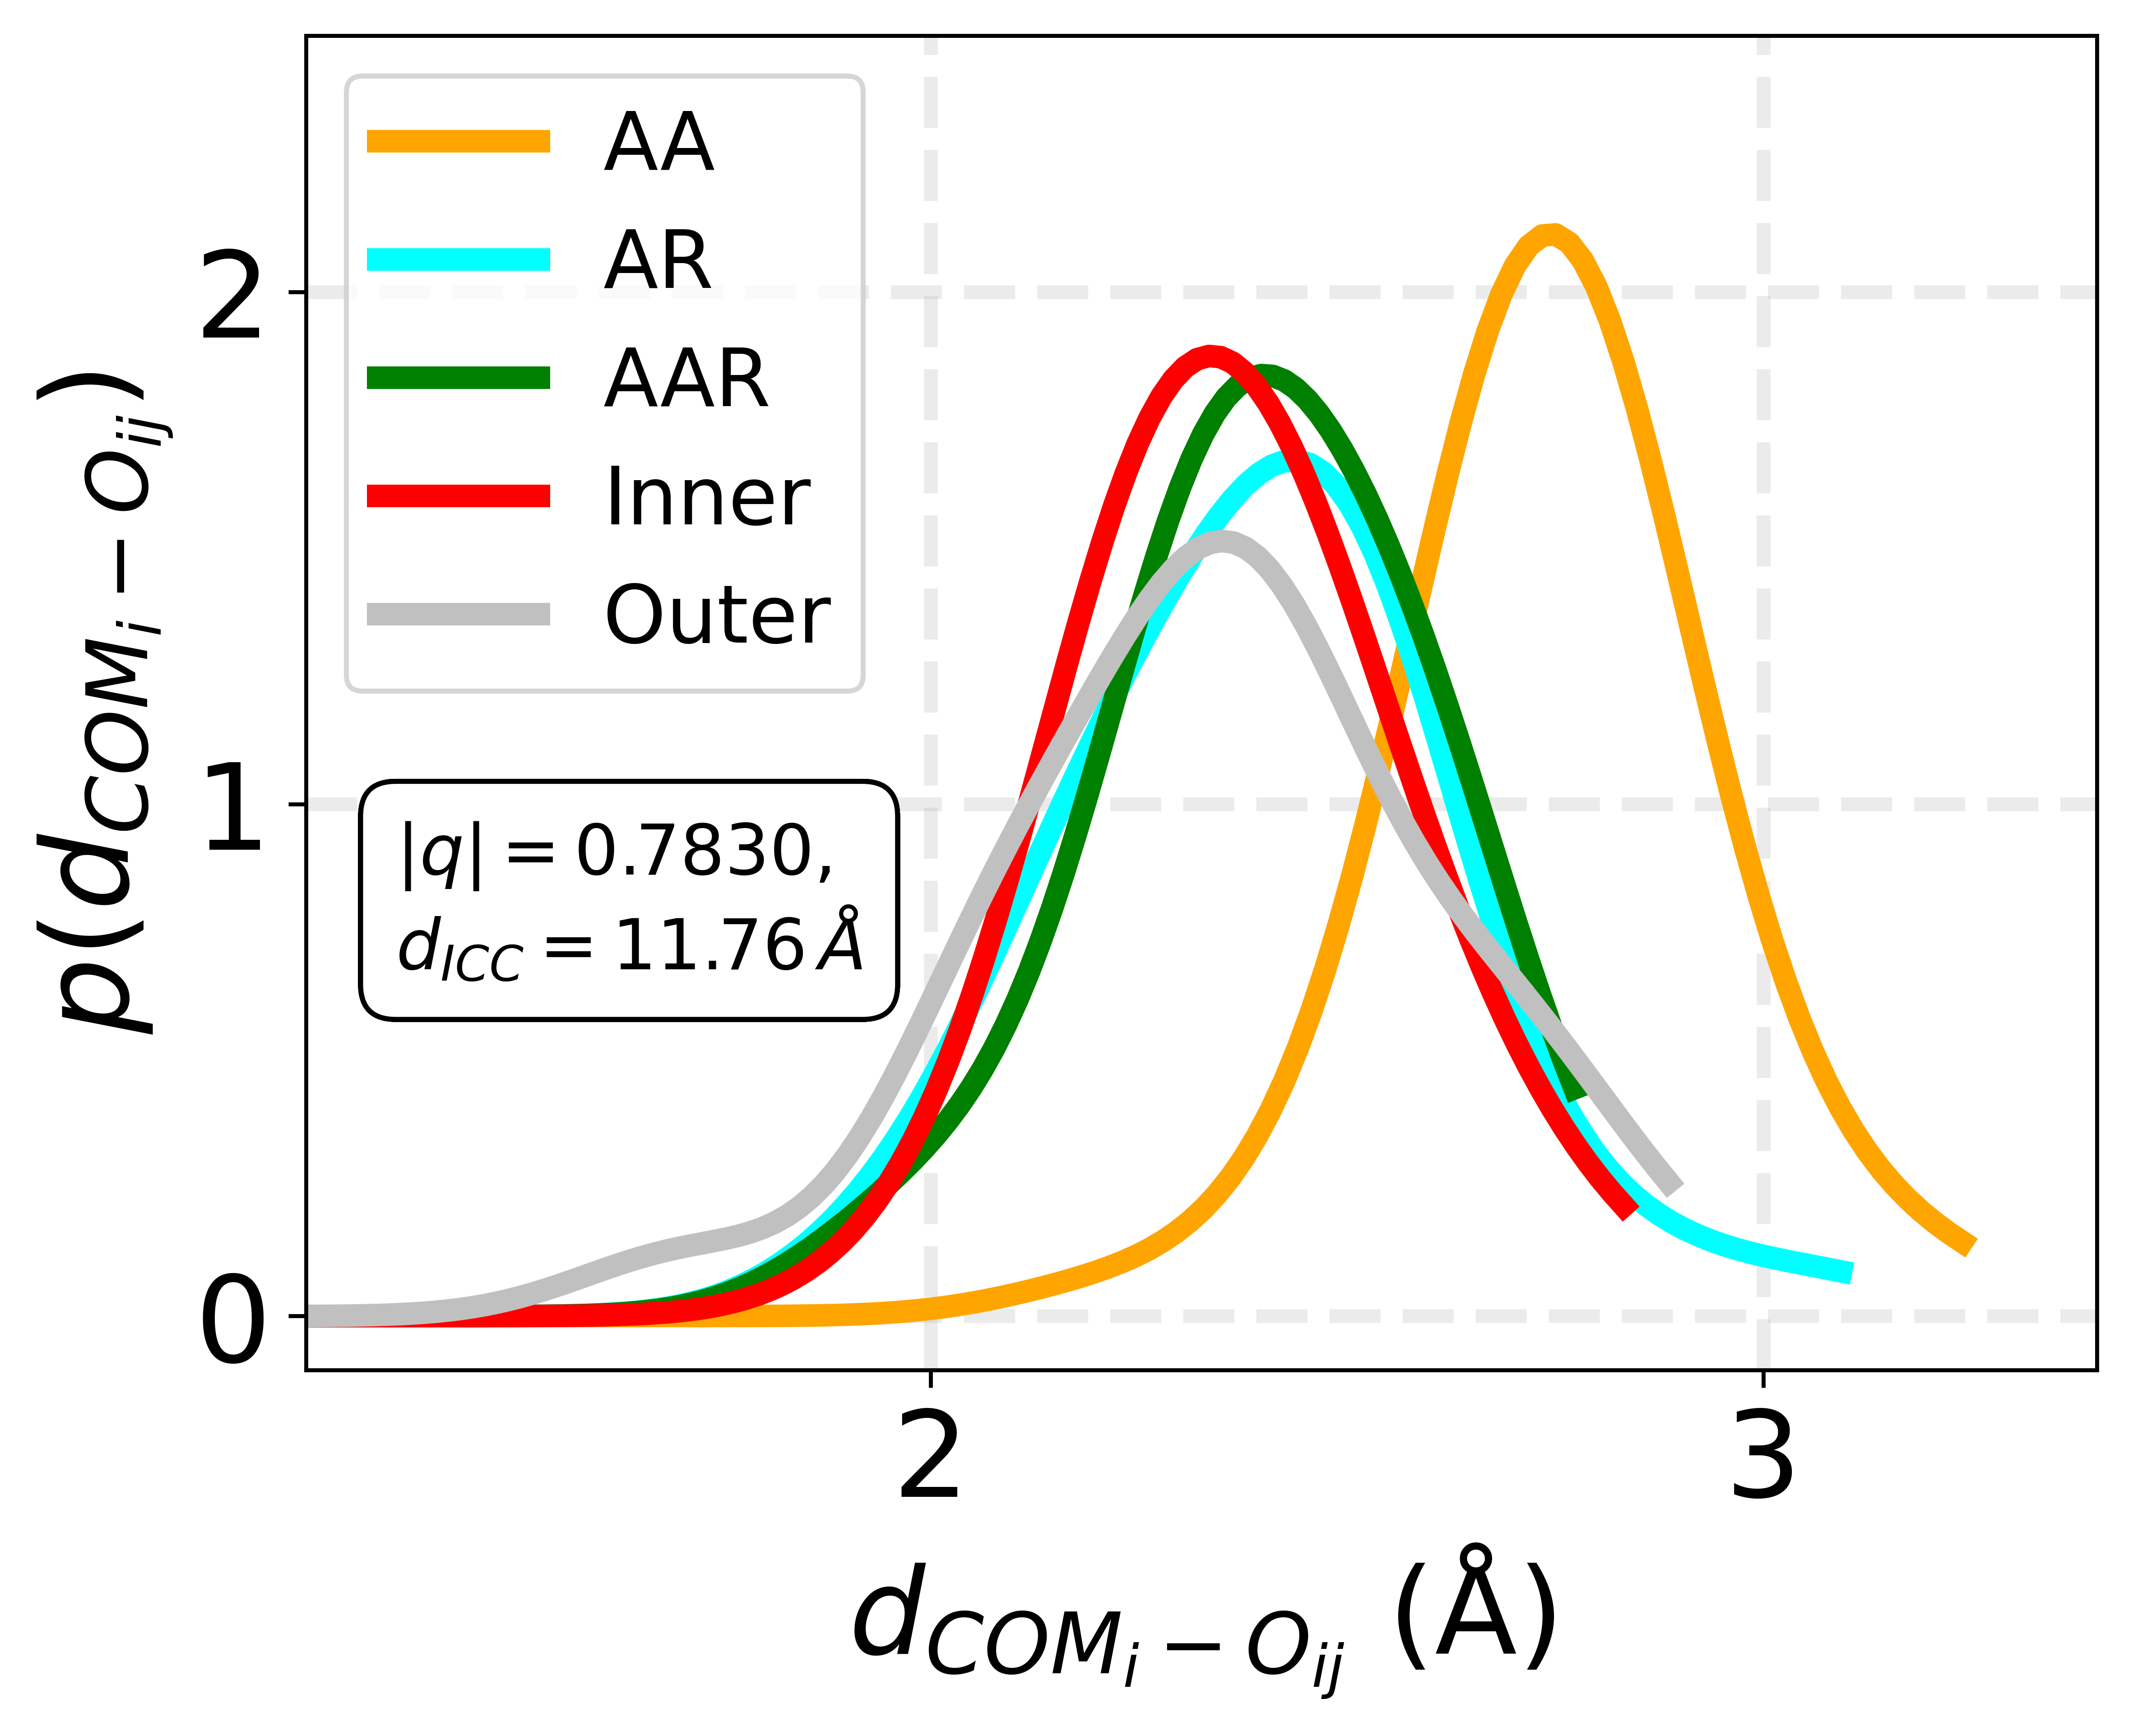

In [2]:
# Plotting Oxygen-COM Distance Probability Functions for all configurations
plt.figure(dpi=800)
colors = ['orange', 'cyan', 'green', 'red', 'silver']
c = 0
for i, (config, distances) in enumerate(oxygen_com_distances_data.items()):
    if distances:
        distances = np.array(distances)
        # Compute probability density
        # Compute probability density
        desired_bandwidth = 1/8

        # Custom bandwidth method
        def fixed_bandwidth_method(data_set,target_bandwidth):
            std_dev = np.std(data_set)
            return target_bandwidth / std_dev  # Compute covariance factor for desired bandwidth
        
        fixed_bandwidth = fixed_bandwidth_method(distances, desired_bandwidth)
        density = gaussian_kde(distances,bw_method=fixed_bandwidth)
        xs = np.linspace(0, distances.max(), 200)
        density_values = density(xs)
        # Find the x-value where the density is highest
        # Calculate the mean of the data
        peak_index = np.argmax(density_values)
        #density_values = density_values/density_values[peak_index]
        #mean_value = np.mean(density_values)

        # Find the index of the element closest to the mean
        #peak_index = np.argmin(np.abs(density_values - mean_value))
        peak_x = xs[peak_index]
        # Plot the density function
        plt.rc('xtick',labelsize=24)
        plt.rc('ytick',labelsize=24)
        plt.plot(xs, density_values, linewidth=4.5, color=colors[i % len(colors)], label=f'{config}')
        # Add vertical dashed line at peak density
        #plt.axvline(x=peak_x, linewidth=4.5, color=colors[i % len(colors)], linestyle='--')
        plt.xlim(1.25,None)
        plt.ylim(None,2.5)
        plt.grid(True,axis='both',which='minor',linestyle='--', alpha=0.5,linewidth=7.5,zorder=1)
        plt.legend(loc="center left", prop={'size': 28})
        plt.annotate(r'$|q| = 0.7830$,'+'\n'+'$d_{ICC} = 11.76 \, \AA$', xy=(0.05, 0.3), xycoords='axes fraction', 
                     fontsize=14, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.grid(True, axis='both', which='minor', linestyle='--', alpha=0.5, linewidth=3.5, zorder=1)
        plt.grid(True, axis='both', which='major', linestyle='--', alpha=0.25, linewidth=2.75, zorder=1)
        #plt.grid(True,axis='both',which='major',linestyle='-', alpha=0.5,linewidth=2.75,zorder=1)
    else:
        print(f"No distances to plot for configuration {config}.")

#plt.xlabel('Oxygen-Center of Mass Distance (Å)',fontsize=24)
plt.xlabel(r'$d_{COM_{i}-O_{ij}}$ (Å)',fontsize=24)
#plt.ylabel('Probability Density',fontsize=24)
plt.ylabel('$p(d_{COM_{i}-O_{ij}})$',fontsize=24)
#plt.title('Oxygen-COM Distance Probability Functions',fontsize=28)
plt.legend(prop={'size': 16})
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\,'
<>:28: SyntaxWarning: invalid escape sequence '\,'
/var/folders/ys/y877k0vd3bj8jdjg6z66dk980000gn/T/ipykernel_16874/2021695901.py:28: SyntaxWarning: invalid escape sequence '\,'
  plt.annotate(r'$|q| = 0.7830$,'+'\n'+'$d_{ICC} = 11.76 \, \AA$', xy=(0.65, 0.05), xycoords='axes fraction',


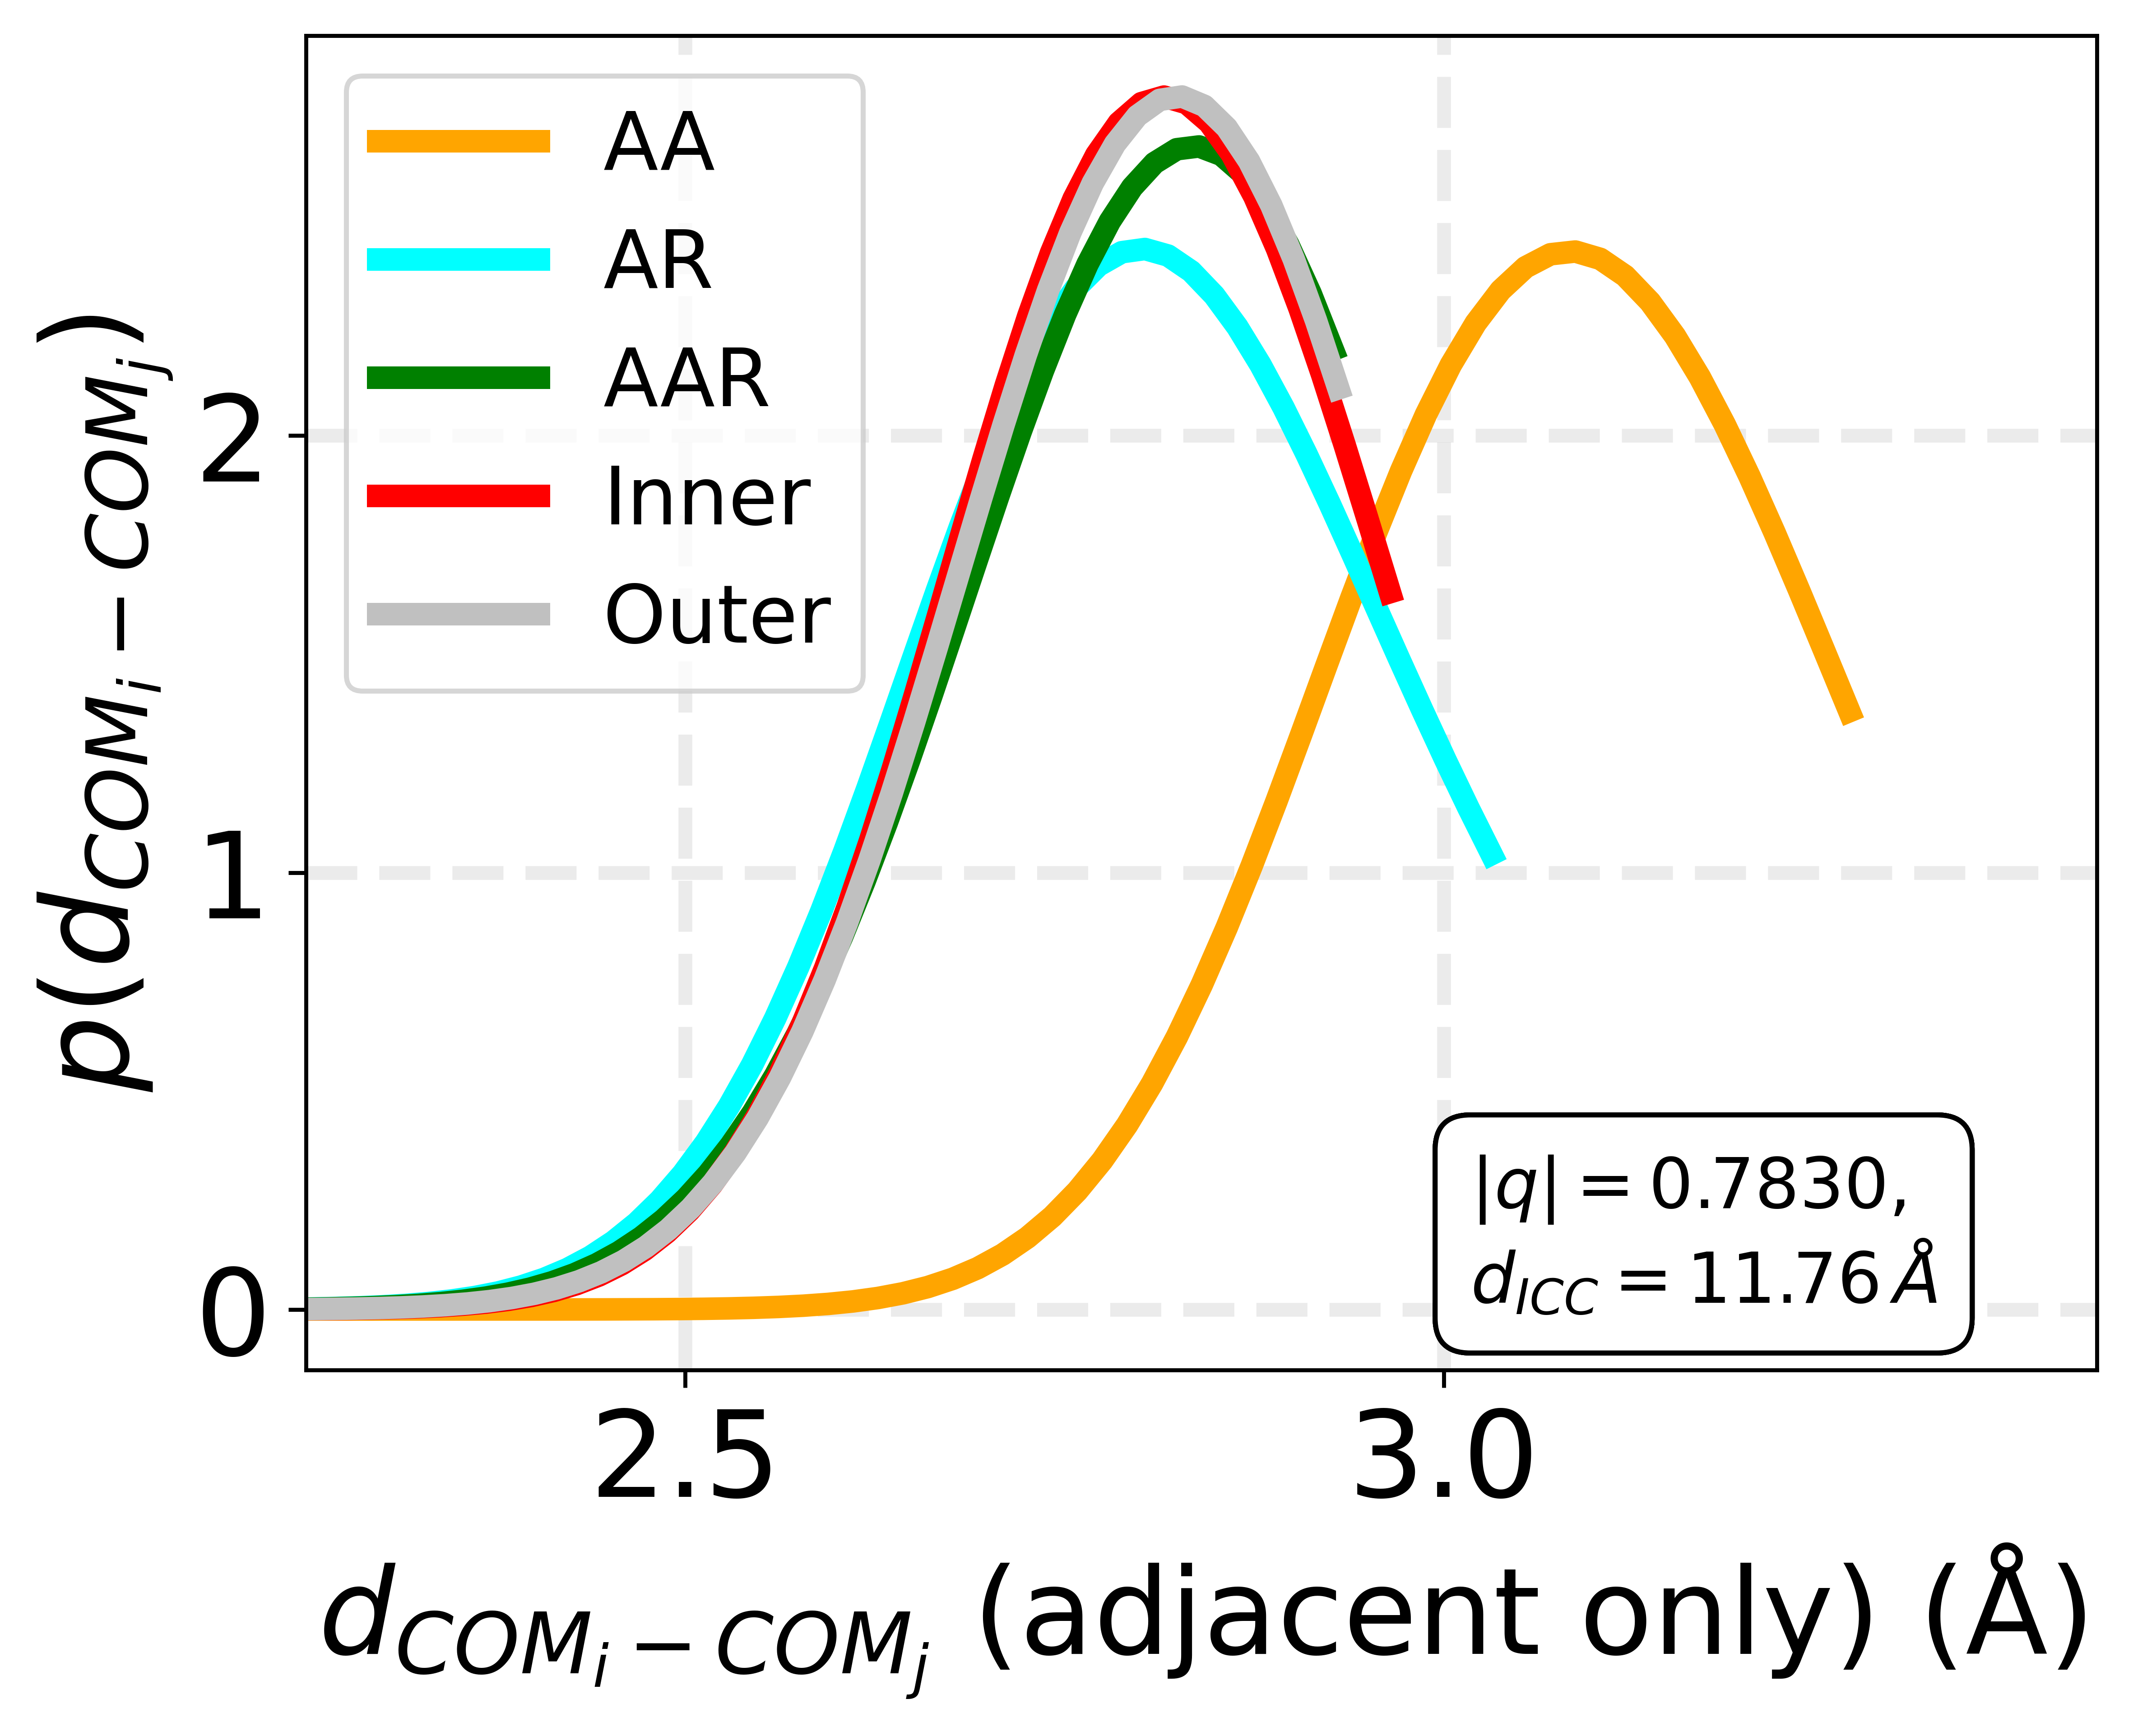

In [8]:
# Plotting Layer COM Distance Probability Functions for all configurations
plt.figure(dpi=800)
for i, (config, distances) in enumerate(layer_com_distances_data.items()):
    if distances:
        distances = np.array(distances)
        # Compute probability density
        desired_bandwidth = 1/8

        # Custom bandwidth method
        def fixed_bandwidth_method(data_set,target_bandwidth):
            std_dev = np.std(data_set)
            return target_bandwidth / std_dev  # Compute covariance factor for desired bandwidth
        
        fixed_bandwidth = fixed_bandwidth_method(distances, desired_bandwidth)
        density = gaussian_kde(distances,bw_method=fixed_bandwidth)
        xs = np.linspace(0, distances.max(), 200)
        density_values = density(xs)
        # Find the x-value where the density is highest
        #peak_index = np.argmax(density_values)
        peak_index = np.argmax(density_values)
        #density_values = density_values/density_values[peak_index]
        peak_x = xs[peak_index]
        # Plot the density function
        plt.plot(xs, density_values, linewidth=4.5, color=colors[i % len(colors)], label=f'{config}')
        # Add vertical dashed line at peak density
        #plt.axvline(x=peak_x, linewidth=4.5, color=colors[i % len(colors)], linestyle='--')
        plt.xlim(2.2,None)
        plt.annotate(r'$|q| = 0.7830$,'+'\n'+'$d_{ICC} = 11.76 \, \AA$', xy=(0.65, 0.05), xycoords='axes fraction', 
                     fontsize=14, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.grid(True, axis='both', which='minor', linestyle='--', alpha=0.5, linewidth=3.5, zorder=1)
        plt.grid(True, axis='both', which='major', linestyle='--', alpha=0.25, linewidth=2.75, zorder=1)
    else:
        print(f"No COM distances to plot for configuration {config}.")

#plt.xlabel('Distance Between Adjacent Layer COMs (Å)',fontsize=24)
plt.xlabel(r'$d_{COM_{i}-COM_{j}}$ (adjacent only) (Å)',fontsize=24)
plt.ylabel('$p(d_{COM_{i}-COM_{j}})$',fontsize=24)
plt.xlim(2.25,None)
#plt.ylabel('Probability Density',fontsize=24)
#plt.title('Layer to Layer COM Distance Probability Functions')
plt.legend(loc='best',prop={'size': 16})
plt.show()

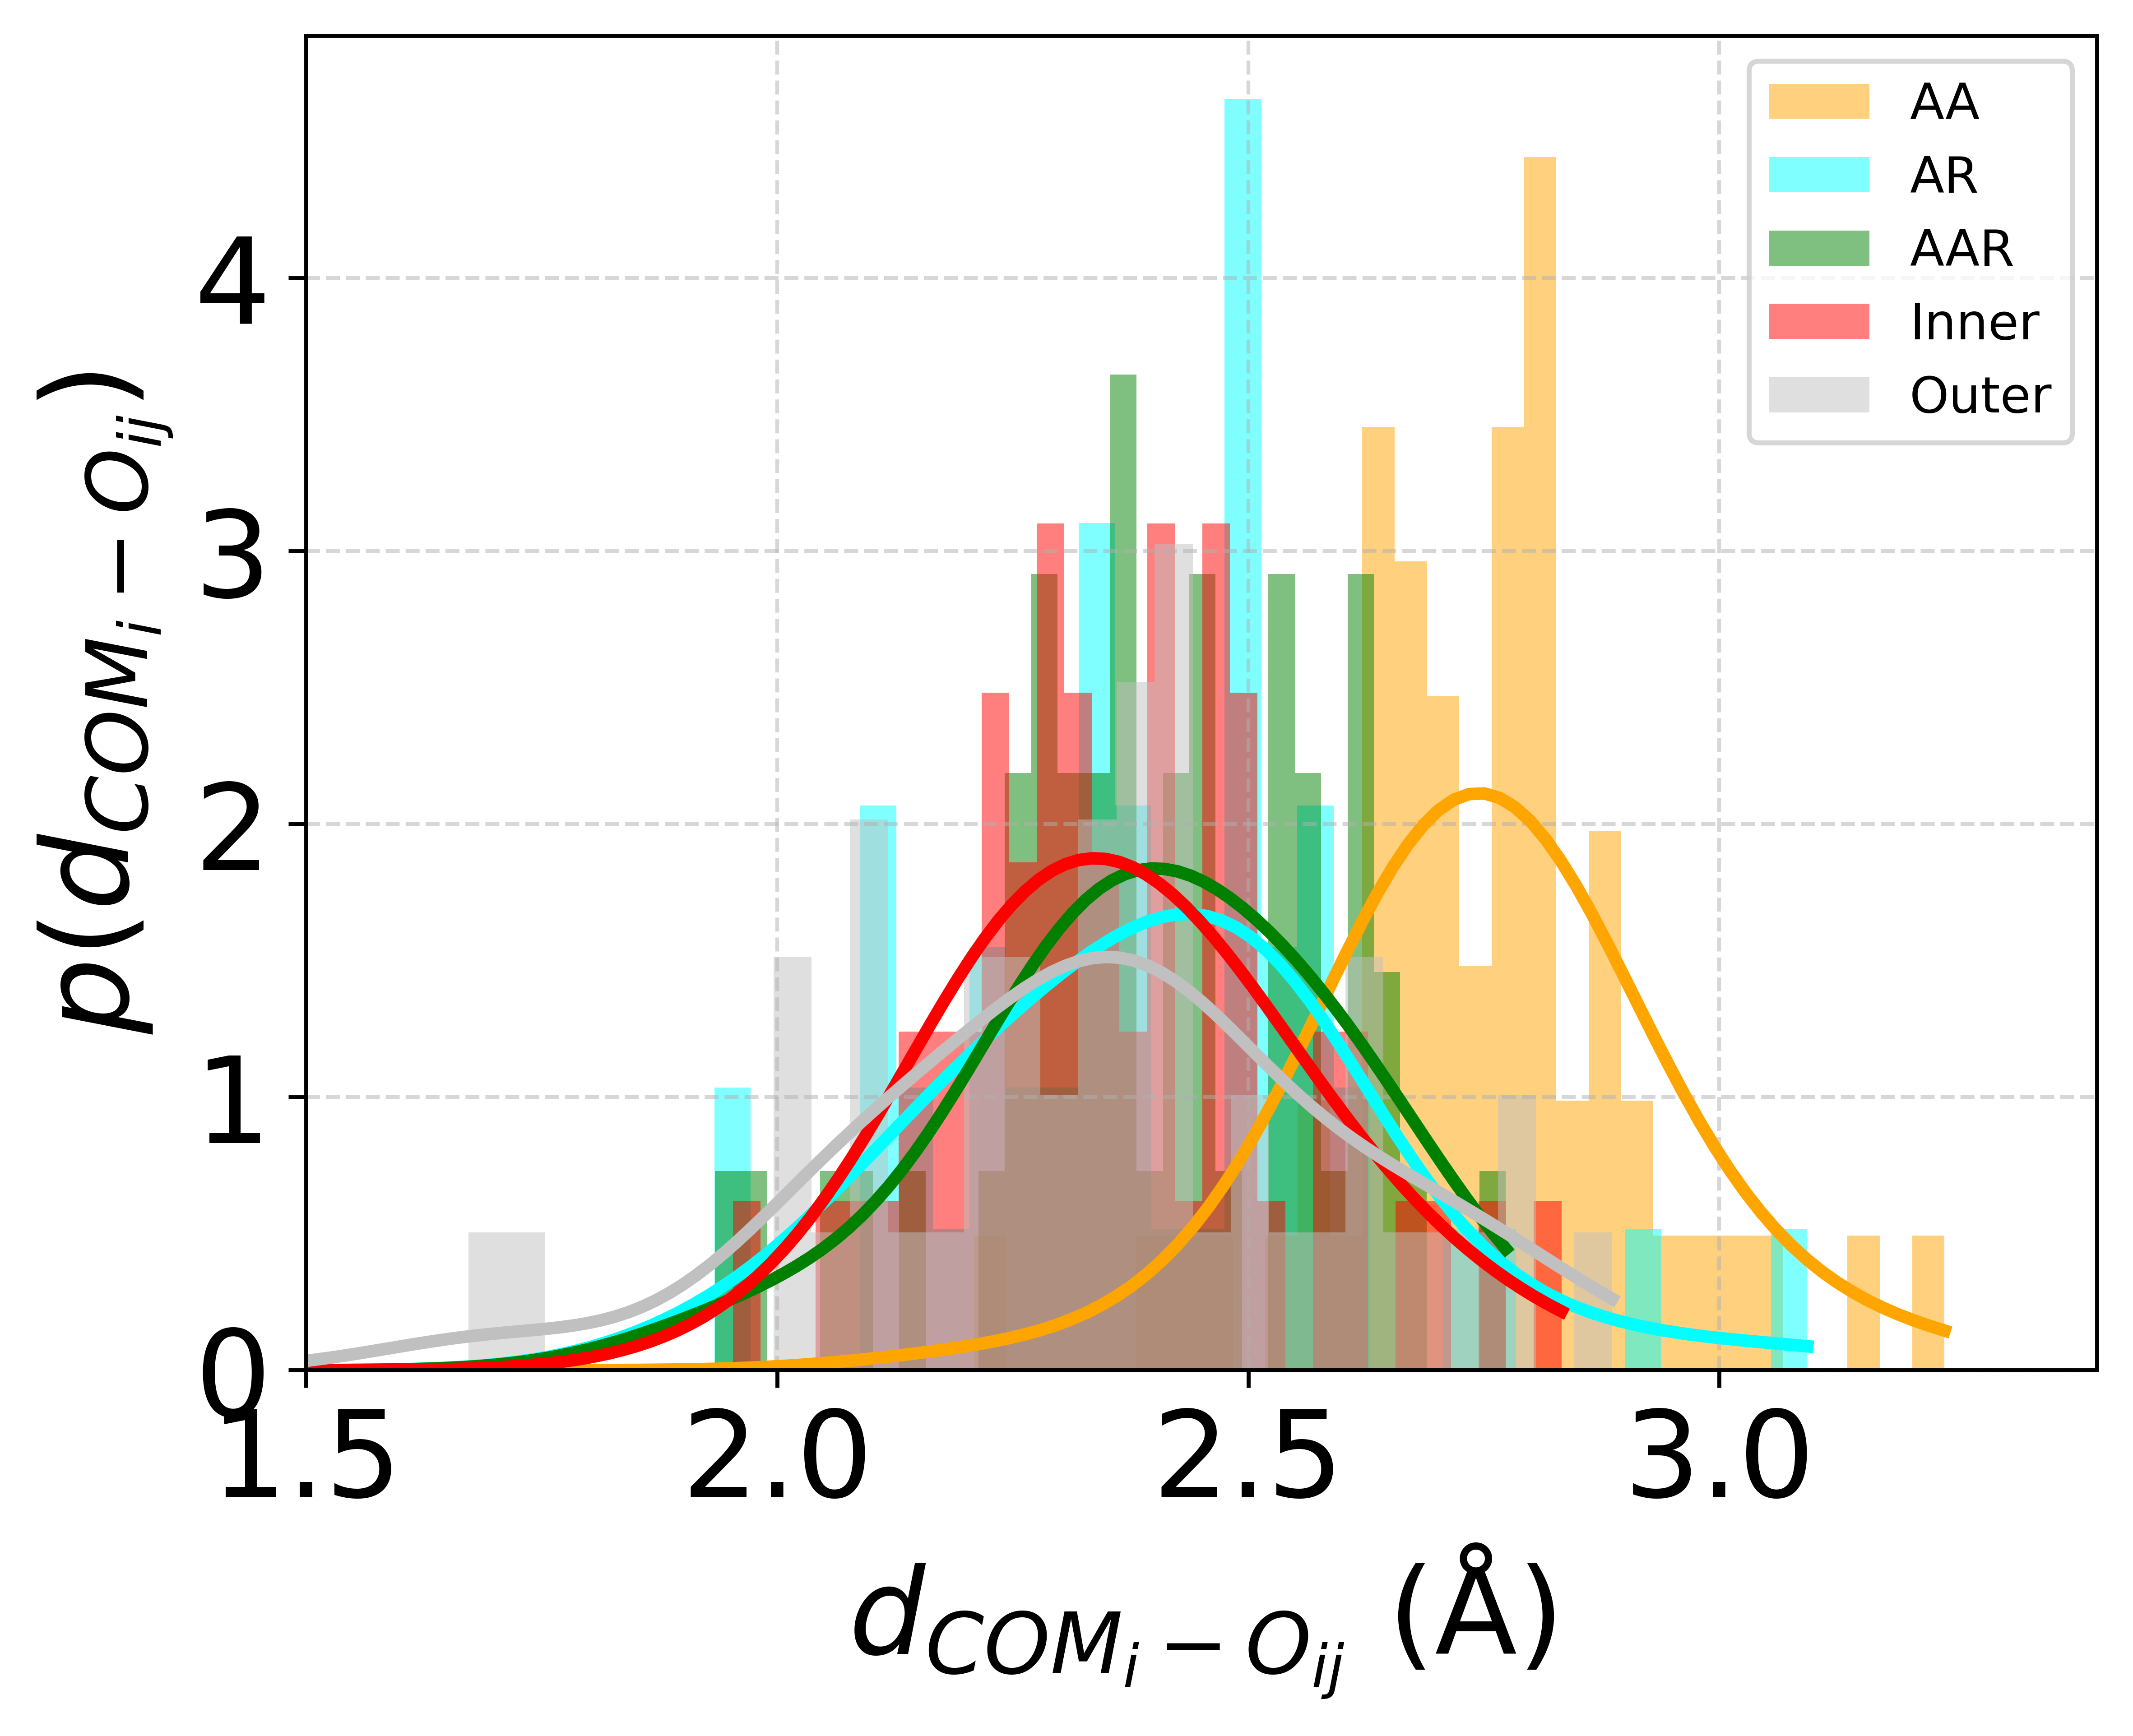

In [5]:
# Plotting Oxygen-COM Distance Probability Functions as histogram with KDE
plt.figure(dpi=800)
colors = ['orange', 'cyan', 'green', 'red', 'silver']
for i, (config, distances) in enumerate(oxygen_com_distances_data.items()):
    if distances:
        distances = np.array(distances)
        # Plot histogram with density (KDE)
        plt.hist(distances, bins=30, density=True, alpha=0.5, color=colors[i % len(colors)], label=f'{config}')
        # Compute and plot KDE
        desired_bandwidth = 1/8

        # Custom bandwidth method
        def fixed_bandwidth_method(data_set,target_bandwidth):
            std_dev = np.std(data_set)
            return target_bandwidth / std_dev  # Compute covariance factor for desired bandwidth
        
        fixed_bandwidth = fixed_bandwidth_method(distances, desired_bandwidth)
        density = gaussian_kde(distances,bw_method=fixed_bandwidth)
        xs = np.linspace(0, distances.max(), 200)
        density_values = density(xs)
        plt.plot(xs, density_values, linewidth=2.5, color=colors[i % len(colors)])
        plt.xlim(1.5,None)
    else:
        print(f"No distances to plot for configuration {config}.")

plt.xlabel(r'$d_{COM_{i}-O_{ij}}$ (Å)', fontsize=24)
plt.ylabel('$p(d_{COM_{i}-O_{ij}})$', fontsize=24)
plt.grid(True, axis='both', linestyle='--', alpha=0.5, linewidth=0.75, zorder=1)
plt.legend()
plt.show()

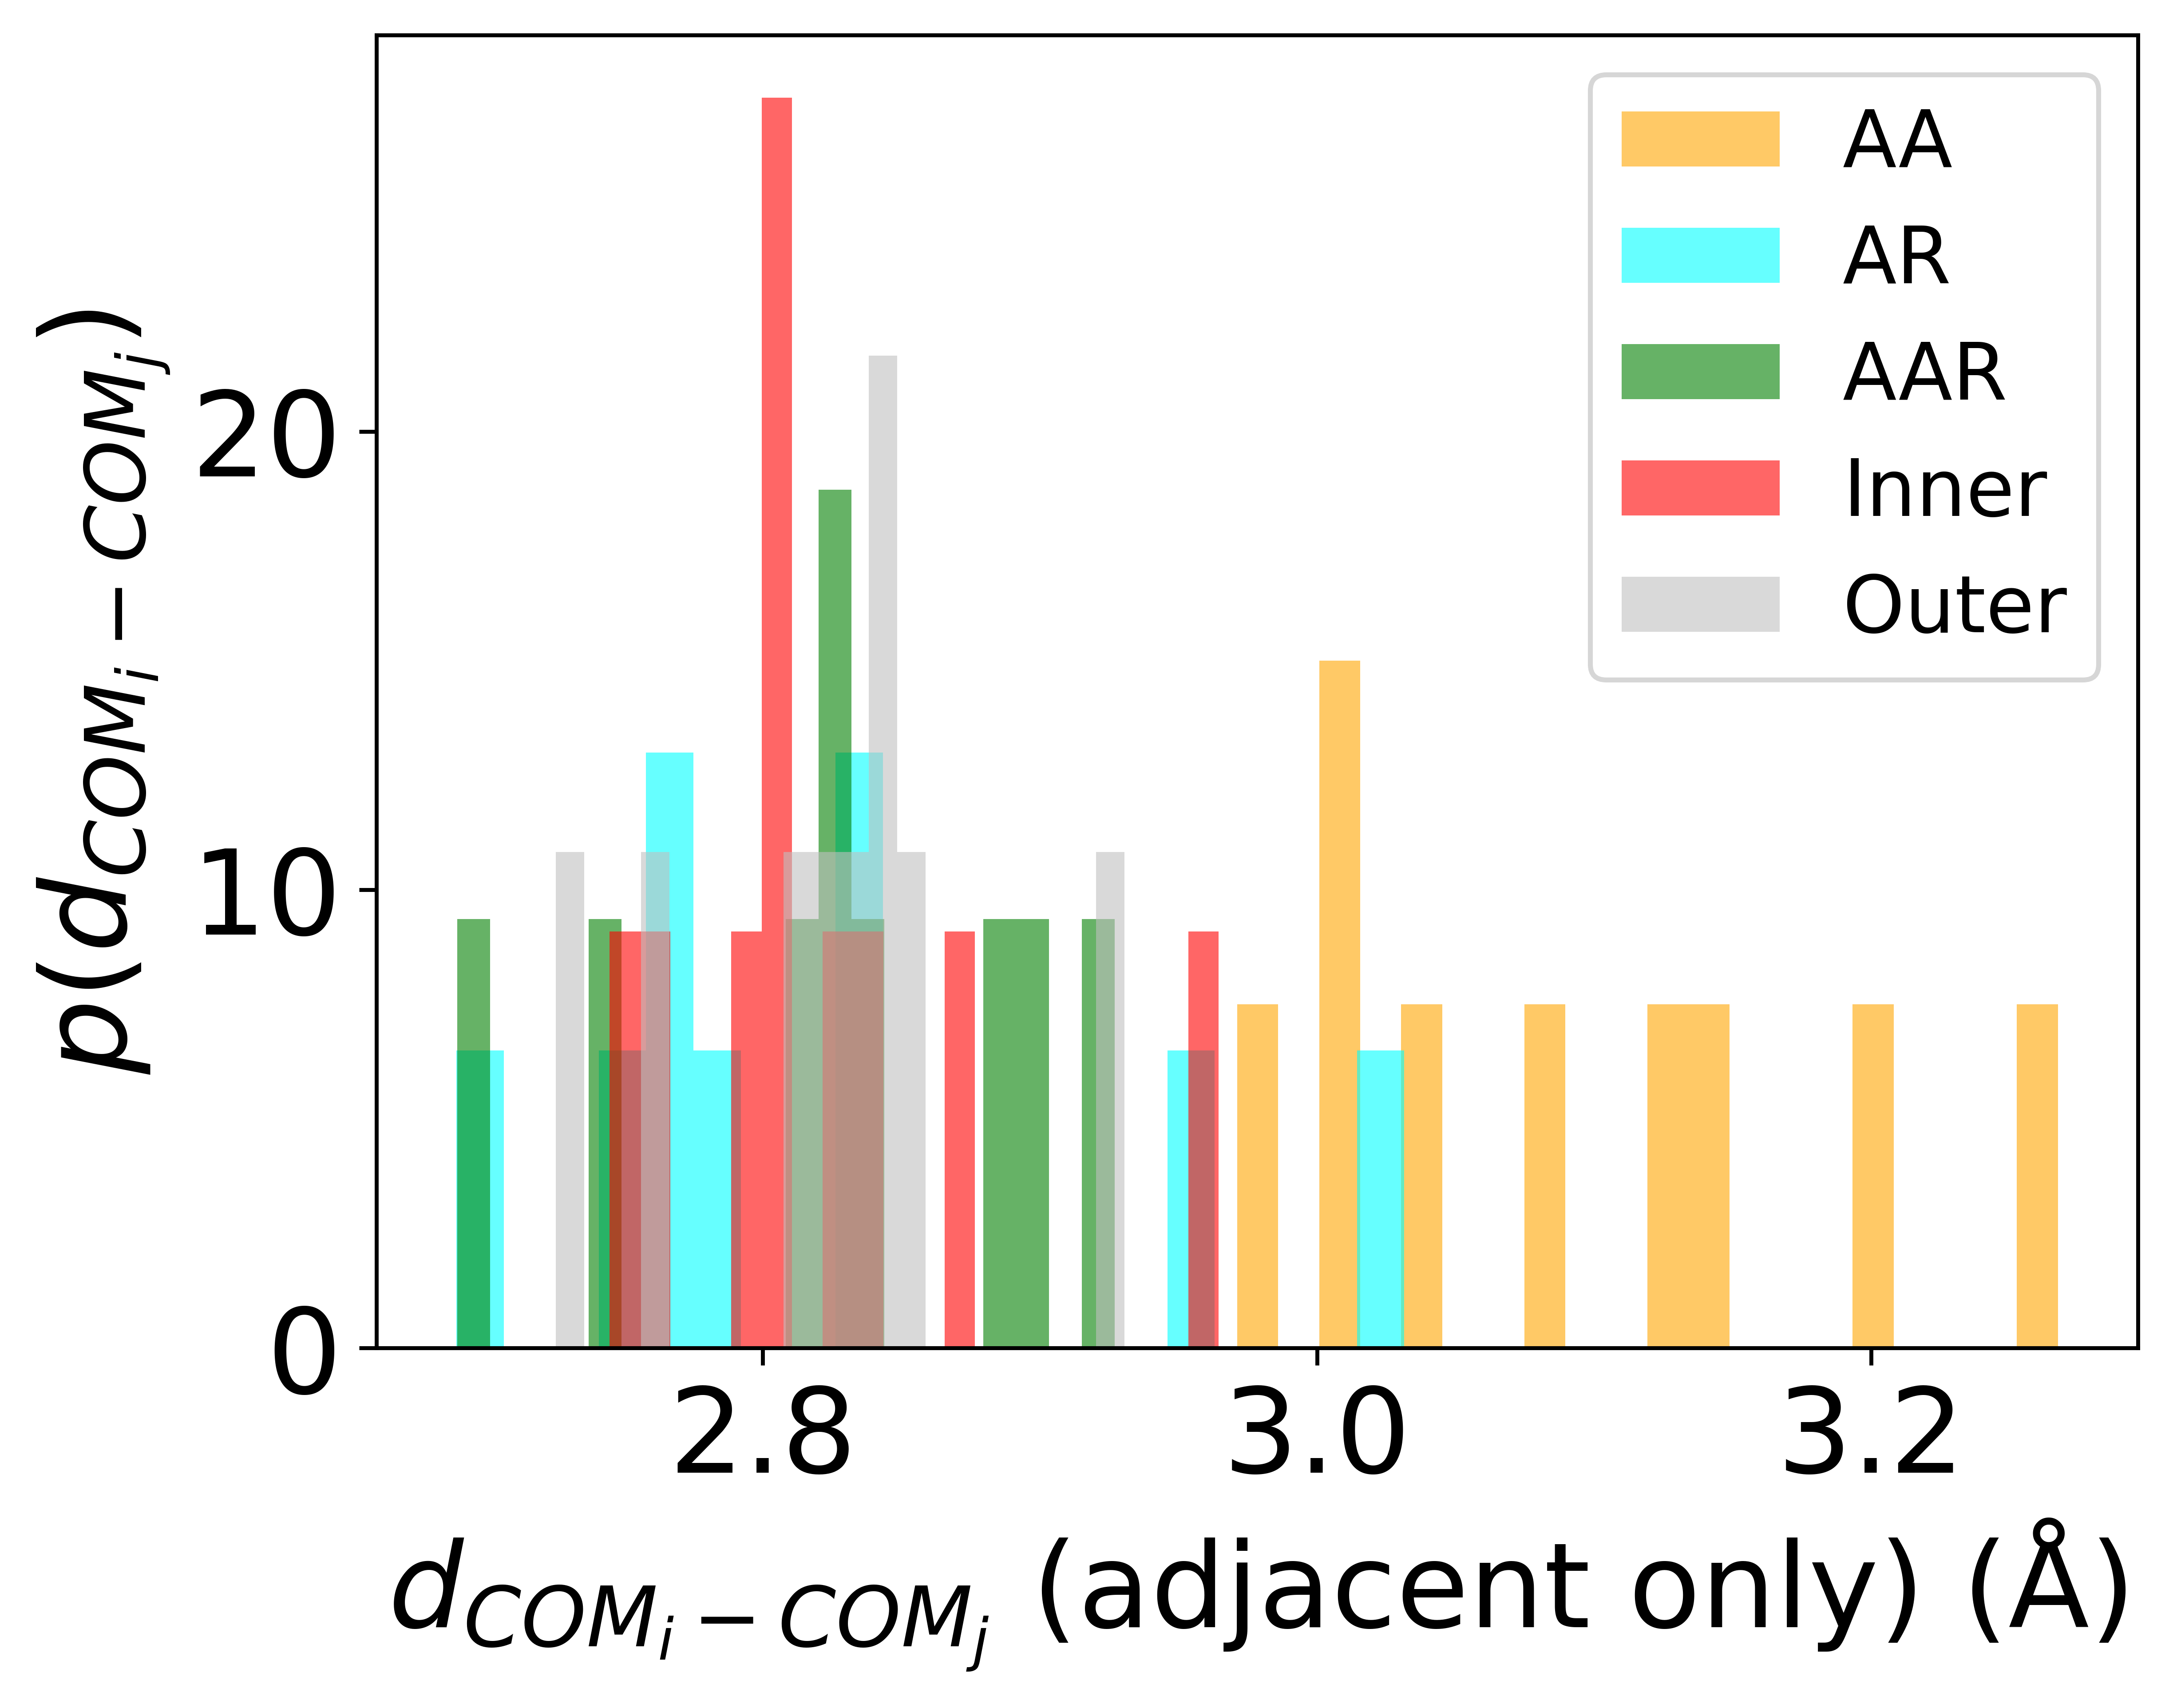

In [6]:
# Plotting histograms for all configurations
plt.figure(dpi=800)
for i, (config, distances) in enumerate(layer_com_distances_data.items()):
    if distances:
        distances = np.array(distances)
        # Plot histogram to show density distribution
        plt.hist(distances, bins=20, density=True, alpha=0.6, color=colors[i % len(colors)], label=f'{config}')
    else:
        print(f"No COM distances to plot for configuration {config}.")

# Labels and formatting
plt.xlabel(r'$d_{COM_{i}-COM_{j}}$ (adjacent only) (Å)', fontsize=24)
plt.ylabel('$p(d_{COM_{i}-COM_{j}})$', fontsize=24)
plt.legend(loc='best', prop={'size': 16})
plt.show()